In [1]:
import mrob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/konstantin/.local/lib/python3.6/site-packages/m

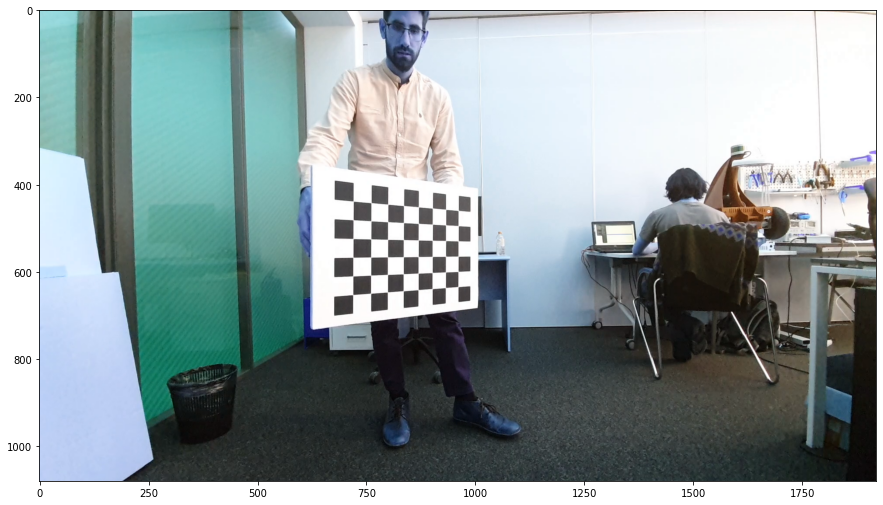

In [10]:
#load data:
# file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/chess1.png"
file_path = "/home/konstantin/datasets/bandeja-sequence/temp_gonzalo/chess1.png"
#file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/people2.png"
img = cv.imread(file_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)

{'intrinsics': array([[726.09416884,   0.        , 964.68602275],
       [  0.        , 729.2560497 , 552.51457462],
       [  0.        ,   0.        ,   1.        ]]), 'dist_coeff': array([[ 0.00385203, -0.01636995,  0.00015895, -0.0012709 ,  0.        ]]), 'undist_intrinsics': array([[615.07110596,   0.        , 952.62381015],
       [  0.        , 618.35211182, 558.1062187 ],
       [  0.        ,   0.        ,   1.        ]])}


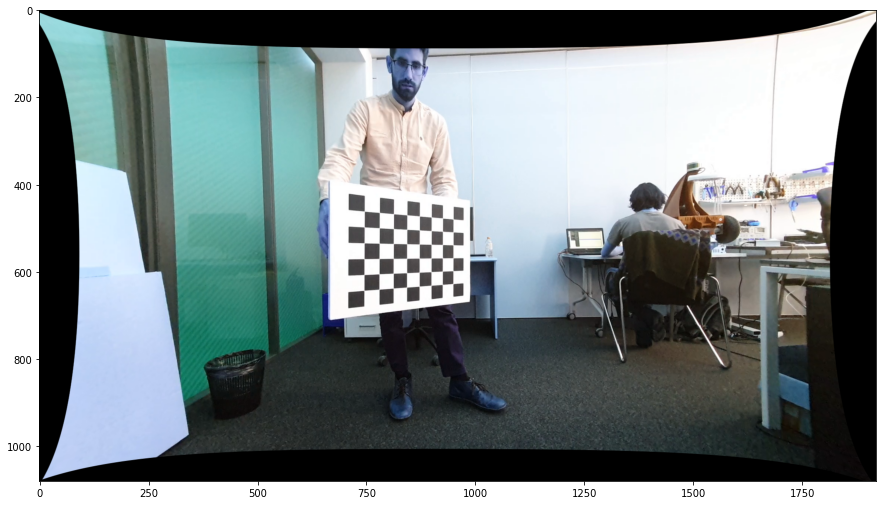

In [13]:
# calib_intrinsincs = np.load('calib_output/s102_intrinsics.npy', allow_pickle=True).item()
calib_intrinsincs = np.load('calib_output/s10_intrinsics.npy', allow_pickle=True).item()
intrinsics = calib_intrinsincs['intrinsics']
dist_coeff = calib_intrinsincs['dist_coeff']
undist_intrinsics = calib_intrinsincs['undist_intrinsics']
print(calib_intrinsincs)
undist_img = cv.undistort(img, intrinsics, dist_coeff, None, undist_intrinsics)
plt.figure(figsize=(15, 15))
plt.imshow(undist_img)

(1080, 1920) (93, 88, 1722, 918)


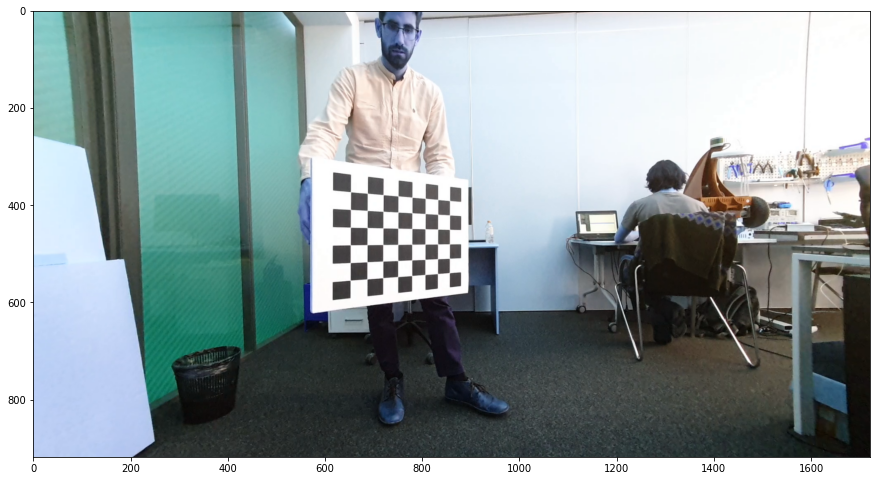

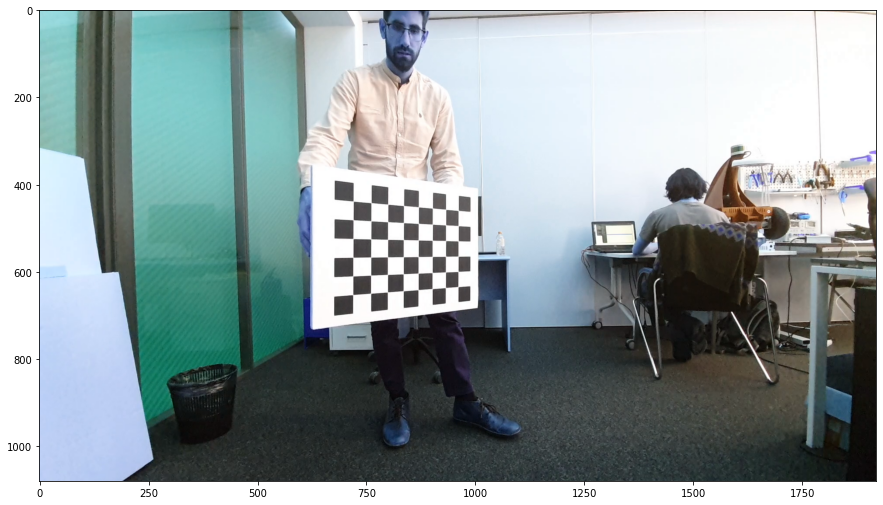

In [14]:
#crop the image
h, w = img.shape[:2]
_, roi = cv.getOptimalNewCameraMatrix(intrinsics, dist_coeff, (w,h), 1, (w,h))
print(img.shape[:2],roi)
x, y, w, h = roi
undist_img = undist_img[y:y+h, x:x+w]
plt.figure(figsize=(15, 15))
plt.imshow(undist_img)
plt.figure(figsize=(15, 15))
plt.imshow(img)

# Load PC

In [116]:
import open3d as o3d
# file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/chess1.pcd"
file_path = "/home/konstantin/datasets/bandeja-sequence/temp_gonzalo/chess1.pcd"
#file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/people2.pcd"
pcd = o3d.io.read_point_cloud(file_path)
# T = np.array([[ 0.99696022, -0.00162089,  0.07789536, -0.2221667 ],
#                [-0.00699329,  0.99388633,  0.11018643,  0.03609816],
#                [-0.07759773, -0.11039623,  0.99085381,  0.05171391],
#                [ 0.        ,  0.        ,  0.        ,  1.        ]])
T = np.array([[ 0.98923996, -0.01847825,  0.14513046, -0.33 ],
              [ 0.00469689,  0.99549167,  0.09473267,  0.03876539],
              [-0.14622666, -0.09303168,  0.98486693,  0.05219266],
              [ 0.        ,  0.        ,  0.        ,  1.        ]])



T2 = mrob.geometry.SE3().T()
T2[0,3]=-0.28
T2[1,3]=0.01
T2[2,3]=0.05
print(T2)

# T[0,3]=-0.28
pcd.transform(T2)

# pcd = pcd.transform(T)
mesh_box = o3d.geometry.TriangleMesh.create_box(width=0.1,
                                                    height=0.1,
                                                    depth=0.1)
#o3d.visualization.draw_geometries([pcd,mesh_box])

[[ 1.    0.    0.   -0.28]
 [ 0.    1.    0.    0.01]
 [ 0.    0.    1.    0.05]
 [ 0.    0.    0.    1.  ]]


## project point cloud into depth

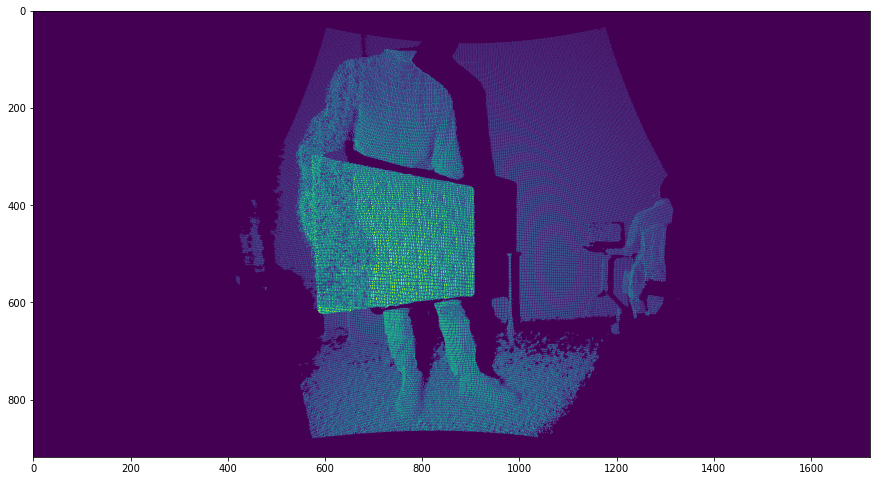

In [117]:
# iterate points and project them into
I = np.zeros(undist_img.shape[:2],np.float32) #very far away, TODO which one is the invalid number?
I2 = np.zeros(undist_img.shape,np.float32)
for P in pcd.points:
    d = np.linalg.norm(P)
    P = P/P[2]
    
    p = undist_intrinsics@P
    
    x, y = int(np.round(p[0])), int(np.round(p[1]))
    if x >= 0 and x < w and y >= 0 and y < h:
        I[y,x]=1/d
        I2[y,x,0] = 1/d
I = I/np.max(I)
I2 = I2/np.max(I2)
plt.figure(figsize=(15, 15))
plt.imshow(I)

In [118]:
# convert images to o3d standard
#rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(undist_img, I)

WARNING - 2021-02-22 17:45:39,290 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


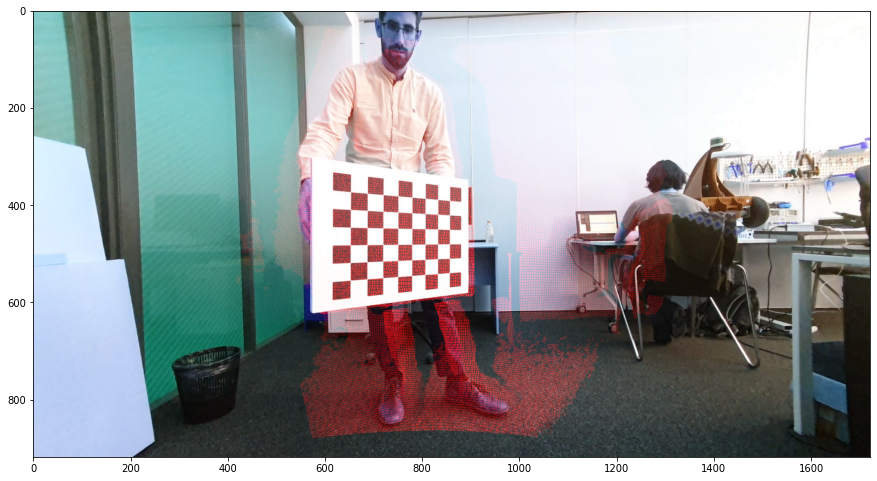

In [119]:
# other option, plot both images with transparencies?
gray = cv.cvtColor(undist_img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(15, 15))
#ji = cv.addWeighted(I, 0.5, gray, 0.5, 0.0) #does not work
#plt.imshow(gray*0.01 + I)
plt.imshow(I2+undist_img/255)
#cv.imwrite('im1.jpg', I2+undist_img/255 )